In [22]:
# Ипортируем необходимые модули
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy import genfromtxt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
# Подгружаем данные
my_data = genfromtxt('https://raw.githubusercontent.com/dmitry-chvdr/aqi_prediction/master/ts_air_quality_index_2013_2020.csv', delimiter=',')

In [3]:
# Формируем таргет
ndata = []
for i in my_data:
  ndata.append(i[-1])
del ndata[0]
n1data = np.array(ndata)

In [4]:
# Формируем признаки
my_data = np.delete(my_data, 0, 0)
raw_data = []
for i in my_data:
  k = np.delete(i,[6,13])
  raw_data.append(k)
  new_data = np.array(raw_data)
raw_data = new_data

In [5]:
# Формируем тренировочный, валидационный и тестовый набор данных
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 1461
num_val_samples: 730
num_test_samples: 731


In [6]:
# Формируем наборы данных (временные ряды со сколзящими окнами)
# https://runebook.dev/ru/docs/tensorflow/keras/utils/timeseries_dataset_from_array

sampling_rate = 2
sequence_length = 10
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 64

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=n1data[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=n1data[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=n1data[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

**2 Линейных слоя **

In [16]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=val_dataset,
                    )

Epoch 1/50
23/23 [==============================] - 1s 26ms/step - loss: 2650.2271 - mae: 38.9259 - val_loss: 2135.6946 - val_mae: 38.2203
Epoch 2/50
23/23 [==============================] - 1s 21ms/step - loss: 2135.1245 - mae: 35.6759 - val_loss: 1928.5063 - val_mae: 33.3980
Epoch 3/50
23/23 [==============================] - 0s 15ms/step - loss: 2053.2761 - mae: 34.8870 - val_loss: 1893.5137 - val_mae: 35.5067
Epoch 4/50
23/23 [==============================] - 0s 14ms/step - loss: 2009.9171 - mae: 34.5931 - val_loss: 1839.4972 - val_mae: 33.9640
Epoch 5/50
23/23 [==============================] - 0s 14ms/step - loss: 1964.1732 - mae: 34.1271 - val_loss: 1955.5148 - val_mae: 37.5145
Epoch 6/50
23/23 [==============================] - 0s 14ms/step - loss: 1934.2772 - mae: 33.7378 - val_loss: 1761.7433 - val_mae: 33.5860
Epoch 7/50
23/23 [==============================] - 0s 14ms/step - loss: 1893.7767 - mae: 33.4204 - val_loss: 1843.7620 - val_mae: 36.3061
Epoch 8/50
23/23 [=========

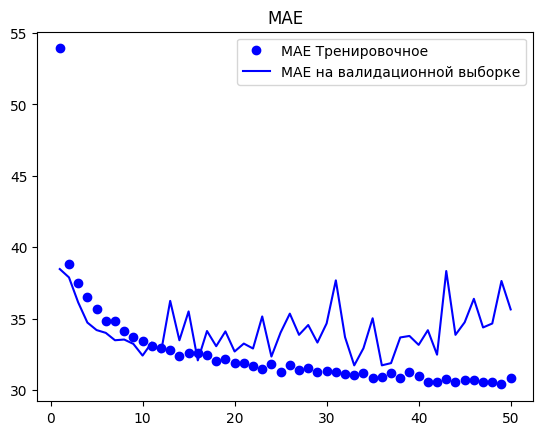

In [8]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="МАЕ Тренировочное")
plt.plot(epochs, val_loss, "b", label="МАЕ на валидационной выборке")
plt.title("МАЕ")
plt.legend()
plt.show()

*Совершенно непонятно, почему на линейном слое такое качество (возможно есть ошибка)*

**Слой с использование LSTM**

In [11]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=val_dataset)

Epoch 1/50
23/23 [==============================] - 4s 40ms/step - loss: 12209.6709 - mae: 100.0769 - val_loss: 11340.8018 - val_mae: 94.4724
Epoch 2/50
23/23 [==============================] - 1s 25ms/step - loss: 11992.9277 - mae: 98.9968 - val_loss: 11125.6201 - val_mae: 93.3360
Epoch 3/50
23/23 [==============================] - 1s 29ms/step - loss: 11816.6064 - mae: 98.1111 - val_loss: 11025.7900 - val_mae: 92.8176
Epoch 4/50
23/23 [==============================] - 1s 25ms/step - loss: 11731.5381 - mae: 97.6870 - val_loss: 10951.0146 - val_mae: 92.4361
Epoch 5/50
23/23 [==============================] - 0s 16ms/step - loss: 11672.7422 - mae: 97.3923 - val_loss: 10904.9961 - val_mae: 92.1873
Epoch 6/50
23/23 [==============================] - 1s 24ms/step - loss: 11629.4922 - mae: 97.1723 - val_loss: 10865.0518 - val_mae: 91.9682
Epoch 7/50
23/23 [==============================] - 0s 17ms/step - loss: 11589.0166 - mae: 96.9634 - val_loss: 10826.8613 - val_mae: 91.7604
Epoch 8/50
2

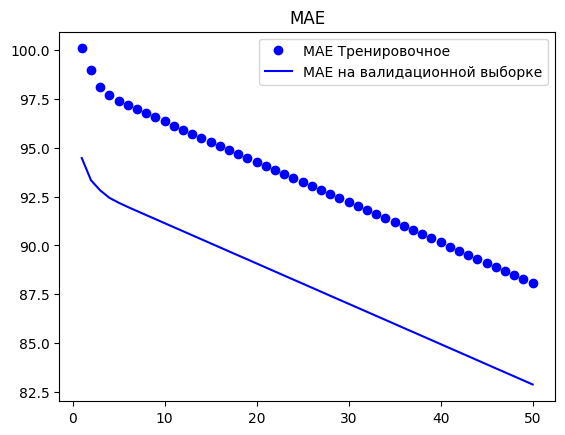

In [12]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="МАЕ Тренировочное")
plt.plot(epochs, val_loss, "b", label="МАЕ на валидационной выборке")
plt.title("МАЕ")
plt.legend()
plt.show()

**LSTM + dropout**

In [14]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32, recurrent_dropout=0.25)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=val_dataset)

Epoch 1/50
23/23 [==============================] - 5s 57ms/step - loss: 12063.3457 - mae: 99.3103 - val_loss: 11073.2119 - val_mae: 92.9715
Epoch 2/50
23/23 [==============================] - 1s 29ms/step - loss: 11619.7412 - mae: 97.0786 - val_loss: 10704.9072 - val_mae: 91.0317
Epoch 3/50
23/23 [==============================] - 1s 30ms/step - loss: 11288.6973 - mae: 95.3954 - val_loss: 10491.4033 - val_mae: 89.9006
Epoch 4/50
23/23 [==============================] - 1s 23ms/step - loss: 11141.2979 - mae: 94.6017 - val_loss: 10334.1953 - val_mae: 89.0248
Epoch 5/50
23/23 [==============================] - 1s 30ms/step - loss: 10981.5586 - mae: 93.7568 - val_loss: 10209.6270 - val_mae: 88.3354
Epoch 6/50
23/23 [==============================] - 1s 23ms/step - loss: 10879.3066 - mae: 93.2223 - val_loss: 10119.6230 - val_mae: 87.8225
Epoch 7/50
23/23 [==============================] - 1s 22ms/step - loss: 10789.3096 - mae: 92.6845 - val_loss: 10034.0264 - val_mae: 87.3337
Epoch 8/50
23

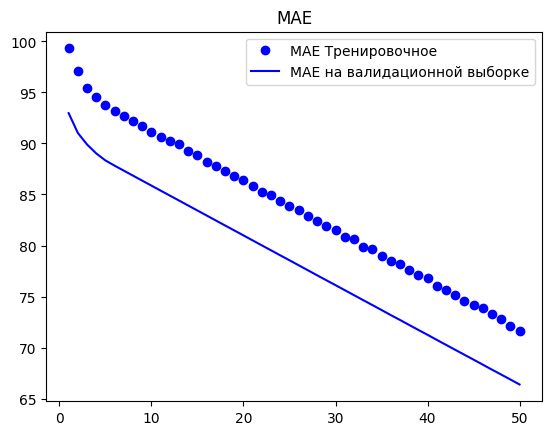

In [15]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="МАЕ Тренировочное")
plt.plot(epochs, val_loss, "b", label="МАЕ на валидационной выборке")
plt.title("МАЕ")
plt.legend()
plt.show()

**GRU (gated recurrent unit) - это более простыые структуры . Добавим сюда так-же рекуррентное прореживание и наложение слоев**

In [17]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(32, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.GRU(32, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=val_dataset)

Epoch 1/50
23/23 [==============================] - 7s 92ms/step - loss: 11515.3174 - mae: 96.5243 - val_loss: 10301.9277 - val_mae: 88.8170
Epoch 2/50
23/23 [==============================] - 1s 39ms/step - loss: 10848.2881 - mae: 93.0473 - val_loss: 9982.2383 - val_mae: 87.0297
Epoch 3/50
23/23 [==============================] - 1s 32ms/step - loss: 10593.8096 - mae: 91.6782 - val_loss: 9828.2744 - val_mae: 86.1459
Epoch 4/50
23/23 [==============================] - 1s 38ms/step - loss: 10440.0928 - mae: 90.8357 - val_loss: 9692.8057 - val_mae: 85.3573
Epoch 5/50
23/23 [==============================] - 1s 60ms/step - loss: 10307.3945 - mae: 90.0849 - val_loss: 9564.2842 - val_mae: 84.6014
Epoch 6/50
23/23 [==============================] - 1s 46ms/step - loss: 10184.7324 - mae: 89.3688 - val_loss: 9438.1387 - val_mae: 83.8526
Epoch 7/50
23/23 [==============================] - 1s 41ms/step - loss: 10032.4395 - mae: 88.5397 - val_loss: 9313.8379 - val_mae: 83.1081
Epoch 8/50
23/23 [=

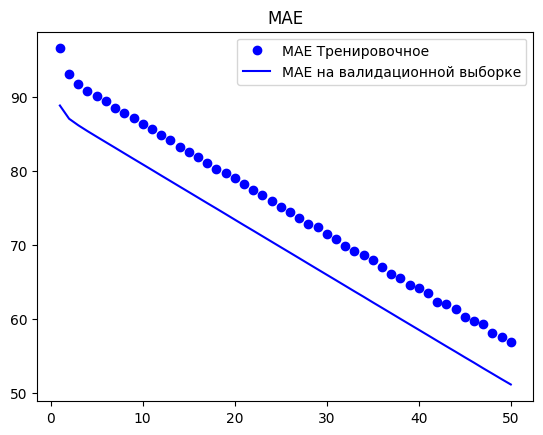

In [18]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="МАЕ Тренировочное")
plt.plot(epochs, val_loss, "b", label="МАЕ на валидационной выборке")
plt.title("МАЕ")
plt.legend()
plt.show()

**Попоробуем существенно больше эпох - 1000**

In [19]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(32, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.GRU(32, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=1000,
                    validation_data=val_dataset)

Epoch 1/1000
23/23 [==============================] - 8s 128ms/step - loss: 11447.9336 - mae: 96.2233 - val_loss: 10214.6348 - val_mae: 88.3446
Epoch 2/1000
23/23 [==============================] - 1s 32ms/step - loss: 10773.4668 - mae: 92.6441 - val_loss: 9937.5615 - val_mae: 86.7746
Epoch 3/1000
23/23 [==============================] - 1s 29ms/step - loss: 10560.2773 - mae: 91.4831 - val_loss: 9785.1670 - val_mae: 85.8966
Epoch 4/1000
23/23 [==============================] - 1s 37ms/step - loss: 10399.5156 - mae: 90.5999 - val_loss: 9651.7441 - val_mae: 85.1168
Epoch 5/1000
23/23 [==============================] - 1s 30ms/step - loss: 10274.1025 - mae: 89.9332 - val_loss: 9524.4229 - val_mae: 84.3655
Epoch 6/1000
23/23 [==============================] - 1s 36ms/step - loss: 10121.2002 - mae: 89.0444 - val_loss: 9398.1064 - val_mae: 83.6136
Epoch 7/1000
23/23 [==============================] - 1s 29ms/step - loss: 9980.8506 - mae: 88.2841 - val_loss: 9273.2275 - val_mae: 82.8634
Epoch

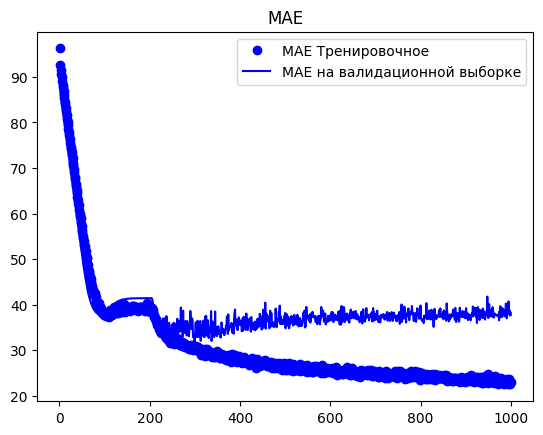

In [20]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="МАЕ Тренировочное")
plt.plot(epochs, val_loss, "b", label="МАЕ на валидационной выборке")
plt.title("МАЕ")
plt.legend()
plt.show()

**Пересчитаем на метрику RMSE**

In [23]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(32, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.GRU(32, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer="rmsprop", loss="mse", metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')])
history = model.fit(train_dataset,
                    epochs=1000,
                    validation_data=val_dataset)

Epoch 1/1000
23/23 [==============================] - 6s 75ms/step - loss: 11618.1260 - rmse: 107.7874 - val_loss: 10429.2715 - val_rmse: 102.1238
Epoch 2/1000
23/23 [==============================] - 1s 37ms/step - loss: 10967.9912 - rmse: 104.7282 - val_loss: 10081.6367 - val_rmse: 100.4074
Epoch 3/1000
23/23 [==============================] - 1s 30ms/step - loss: 10712.9629 - rmse: 103.5034 - val_loss: 9907.3438 - val_rmse: 99.5356
Epoch 4/1000
23/23 [==============================] - 1s 32ms/step - loss: 10531.7822 - rmse: 102.6245 - val_loss: 9765.7637 - val_rmse: 98.8219
Epoch 5/1000
23/23 [==============================] - 1s 31ms/step - loss: 10400.3330 - rmse: 101.9820 - val_loss: 9635.6748 - val_rmse: 98.1615
Epoch 6/1000
23/23 [==============================] - 1s 32ms/step - loss: 10259.0391 - rmse: 101.2869 - val_loss: 9507.1367 - val_rmse: 97.5045
Epoch 7/1000
23/23 [==============================] - 1s 30ms/step - loss: 10126.6328 - rmse: 100.6312 - val_loss: 9382.2549 -

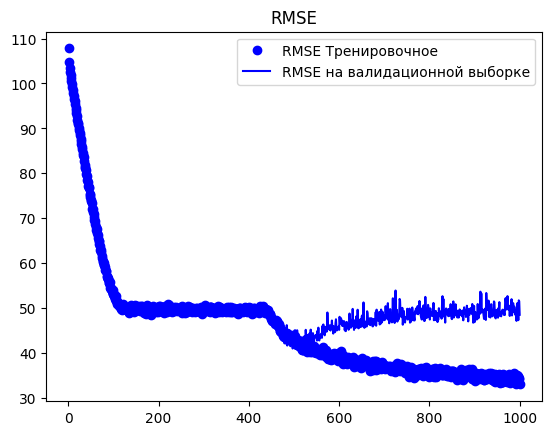

In [24]:
loss = history.history["rmse"]
val_loss = history.history["val_rmse"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="RMSE Тренировочное")
plt.plot(epochs, val_loss, "b", label="RMSE на валидационной выборке")
plt.title("RMSE")
plt.legend()
plt.show()

In [25]:
min(history.history["val_rmse"])

40.990108489990234

*Добится решения лучше чем у Дмитрия Чавдаря не получилось. Принимается его решение.*